In [1]:
# Load libraries
library(tidyverse)
library(survival)
library(survminer)
library(ggplot2)
library(broom)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma




# Load Data Set

In [2]:
# Tahap 1: Import data
data <- read_csv("/kaggle/input/ncctg-lung-cancer-data/cancer.csv") %>% 
    rename(id = `...1`)

New names:
• `` -> `...1`
Rows: 228 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (11): ...1, inst, time, status, age, sex, ph.ecog, ph.karno, pat.karno, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
str(data)

spc_tbl_ [228 × 11] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ id       : num [1:228] 1 2 3 4 5 6 7 8 9 10 ...
 $ inst     : num [1:228] 3 3 3 5 1 12 7 11 1 7 ...
 $ time     : num [1:228] 306 455 1010 210 883 ...
 $ status   : num [1:228] 2 2 1 2 2 1 2 2 2 2 ...
 $ age      : num [1:228] 74 68 56 57 60 74 68 71 53 61 ...
 $ sex      : num [1:228] 1 1 1 1 1 1 2 2 1 1 ...
 $ ph.ecog  : num [1:228] 1 0 0 1 0 1 2 2 1 2 ...
 $ ph.karno : num [1:228] 90 90 90 90 100 50 70 60 70 70 ...
 $ pat.karno: num [1:228] 100 90 90 60 90 80 60 80 80 70 ...
 $ meal.cal : num [1:228] 1175 1225 NA 1150 NA ...
 $ wt.loss  : num [1:228] NA 15 15 11 0 0 10 1 16 34 ...
 - attr(*, "spec")=
  .. cols(
  ..   ...1 = col_double(),
  ..   inst = col_double(),
  ..   time = col_double(),
  ..   status = col_double(),
  ..   age = col_double(),
  ..   sex = col_double(),
  ..   ph.ecog = col_double(),
  ..   ph.karno = col_double(),
  ..   pat.karno = col_double(),
  ..   meal.cal = col_double(),
  ..   wt.loss = co

In [4]:
colnames(data)

[1] "id"        "inst"      "time"      "status"    "age"       "sex"      
 [7] "ph.ecog"   "ph.karno"  "pat.karno" "meal.cal"  "wt.loss"

# Cek Missing Values

In [5]:
# Tahap 2.3.1: Cek Missing Values
data %>%
  summarise(across(everything(), ~ sum(is.na(.)))) %>%
  pivot_longer(everything(), names_to = "variable", values_to = "missing_count") %>%
  filter(missing_count > 0)

variable,missing_count
<chr>,<int>
inst,1
ph.ecog,1
ph.karno,1
pat.karno,3
meal.cal,47
wt.loss,14


Ada terlalu banyak missing value sehingga butuh imputasi.

Warning message:
“Removed 14 rows containing non-finite outside the scale range (`stat_bin()`).”


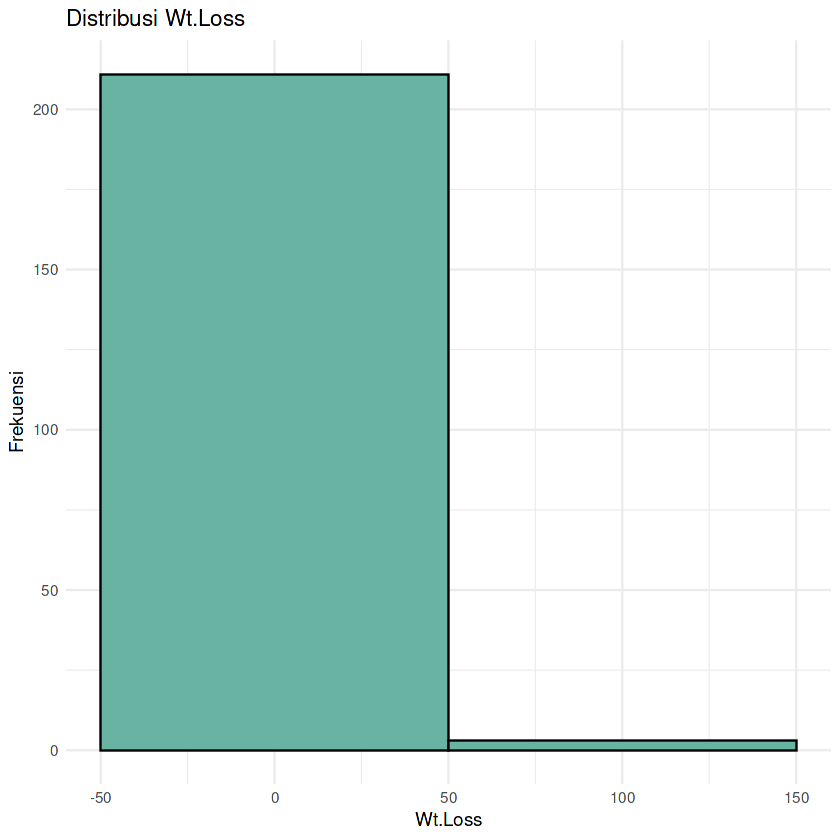

In [6]:
#Cek Kenormalan Meal.cal
ggplot(data, aes(x = wt.loss)) +
  geom_histogram(binwidth = 100, fill = "#69b3a2", color = "black") +
  labs(title = "Distribusi Wt.Loss",
       x = "Wt.Loss",
       y = "Frekuensi") +
  theme_minimal()

Karena tidak menyerupai distribusi normal, maka akan digunakan imputasi median.

In [7]:
#Imputasi Median pada Data yang Banyak Null
data <- data %>%
  mutate(
    wt.loss = if_else(is.na(wt.loss), median(wt.loss, na.rm = TRUE), wt.loss),
  )

# Imputasi dengan Regresi untuk Meal.cal

In [8]:
# Data lengkap (meal.cal tidak NA)
data_complete <- data %>% filter(!is.na(meal.cal))

# Data yang missing meal.cal
data_missing <- data %>% filter(is.na(meal.cal))

In [9]:
model <- lm(meal.cal ~ age + sex + ph.karno + pat.karno + wt.loss, data = data_complete)
summary(model)


Call:
lm(formula = meal.cal ~ age + sex + ph.karno + pat.karno + wt.loss, 
    data = data_complete)

Residuals:
   Min     1Q Median     3Q    Max 
-670.5 -254.4  -12.1  206.5 1762.7 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1950.871    353.098   5.525 1.19e-07 ***
age          -11.432      3.301  -3.463 0.000672 ***
sex         -192.294     60.442  -3.181 0.001737 ** 
ph.karno      -5.199      2.722  -1.910 0.057758 .  
pat.karno      5.290      2.273   2.327 0.021098 *  
wt.loss       -3.734      2.252  -1.658 0.099032 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 380.1 on 173 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.1357,	Adjusted R-squared:  0.1108 
F-statistic: 5.435 on 5 and 173 DF,  p-value: 0.0001138


In [10]:
predicted_mealcal <- predict(model, newdata = data_missing)

In [11]:
data_imputed <- data %>%
  mutate(meal.cal = ifelse(is.na(meal.cal), predicted_mealcal[match(row_number(), which(is.na(meal.cal)))], meal.cal))

In [12]:
summary(data_imputed$meal.cal)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   96.0   725.0   975.0   927.2  1082.7  2600.0       2 

In [13]:
data_imputed %>%
  summarise(across(everything(), ~ sum(is.na(.)))) %>%
  pivot_longer(everything(), names_to = "variable", values_to = "missing_count") %>%
  filter(missing_count > 0)

variable,missing_count
<chr>,<int>
inst,1
ph.ecog,1
ph.karno,1
pat.karno,3
meal.cal,2


Karena sudah tinggal dikit, maka bisa dihapus.

In [14]:
#Hapus Null Sisa
data <- data_imputed %>%
  filter(if_all(everything(), ~ !is.na(.)))

In [15]:
#Cek Kembali
data %>%
  summarise(across(everything(), ~ sum(is.na(.)))) %>%
  pivot_longer(everything(), names_to = "variable", values_to = "missing_count") %>%
  filter(missing_count > 0)

variable,missing_count
<chr>,<int>


Udah ga ada data kosong.

In [16]:
str(data)

tibble [222 × 11] (S3: tbl_df/tbl/data.frame)
 $ id       : num [1:222] 1 2 3 4 5 6 7 8 9 10 ...
 $ inst     : num [1:222] 3 3 3 5 1 12 7 11 1 7 ...
 $ time     : num [1:222] 306 455 1010 210 883 ...
 $ status   : num [1:222] 2 2 1 2 2 1 2 2 2 2 ...
 $ age      : num [1:222] 74 68 56 57 60 74 68 71 53 61 ...
 $ sex      : num [1:222] 1 1 1 1 1 1 2 2 1 1 ...
 $ ph.ecog  : num [1:222] 1 0 0 1 0 1 2 2 1 2 ...
 $ ph.karno : num [1:222] 90 90 90 90 100 50 70 60 70 70 ...
 $ pat.karno: num [1:222] 100 90 90 60 90 80 60 80 80 70 ...
 $ meal.cal : num [1:222] 1175 1225 1071 1150 1029 ...
 $ wt.loss  : num [1:222] 7 15 15 11 0 0 10 1 16 34 ...


Ukuran masih tersisa 222 data point.

# Cek Outlier

In [17]:
# Tahap 2.3.2: Boxplot Outlier untuk variabel numerik
num_vars <- c("age", "ph.karno", "pat.karno", "meal.cal", "wt.loss")

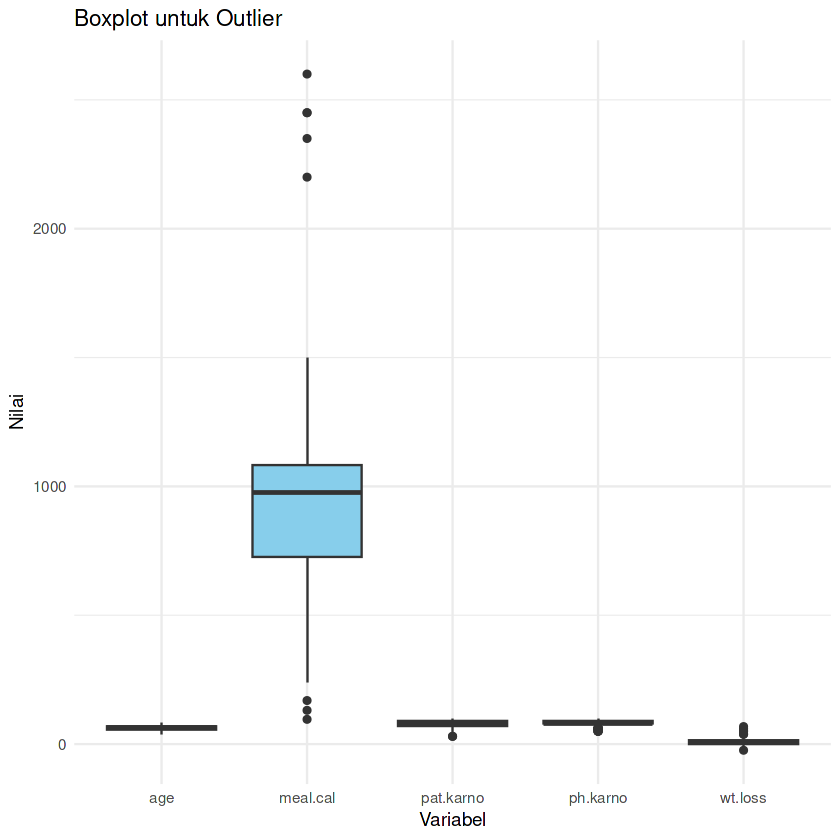

In [18]:
# Buat boxplot per variabel
data %>%
  select(all_of(num_vars)) %>%
  pivot_longer(everything(), names_to = "variable", values_to = "value") %>%
  ggplot(aes(x = variable, y = value)) +
  geom_boxplot(fill = "skyblue") +
  theme_minimal() +
  labs(title = "Boxplot untuk Outlier", x = "Variabel", y = "Nilai")

# Hapus Outlier

In [19]:
remove_outlier_iqr <- function(x) {
  Q1 <- quantile(x, 0.25, na.rm = TRUE)
  Q3 <- quantile(x, 0.75, na.rm = TRUE)
  IQR_val <- Q3 - Q1
  x >= (Q1 - 1.5 * IQR_val) & x <= (Q3 + 1.5 * IQR_val)
}

data_clean <- data %>%
  filter(
    remove_outlier_iqr(age),
    remove_outlier_iqr(meal.cal),
    remove_outlier_iqr(wt.loss)
  )

In [20]:
str(data_clean)

tibble [208 × 11] (S3: tbl_df/tbl/data.frame)
 $ id       : num [1:208] 1 2 3 4 5 6 7 8 9 10 ...
 $ inst     : num [1:208] 3 3 3 5 1 12 7 11 1 7 ...
 $ time     : num [1:208] 306 455 1010 210 883 ...
 $ status   : num [1:208] 2 2 1 2 2 1 2 2 2 2 ...
 $ age      : num [1:208] 74 68 56 57 60 74 68 71 53 61 ...
 $ sex      : num [1:208] 1 1 1 1 1 1 2 2 1 1 ...
 $ ph.ecog  : num [1:208] 1 0 0 1 0 1 2 2 1 2 ...
 $ ph.karno : num [1:208] 90 90 90 90 100 50 70 60 70 70 ...
 $ pat.karno: num [1:208] 100 90 90 60 90 80 60 80 80 70 ...
 $ meal.cal : num [1:208] 1175 1225 1071 1150 1029 ...
 $ wt.loss  : num [1:208] 7 15 15 11 0 0 10 1 16 34 ...


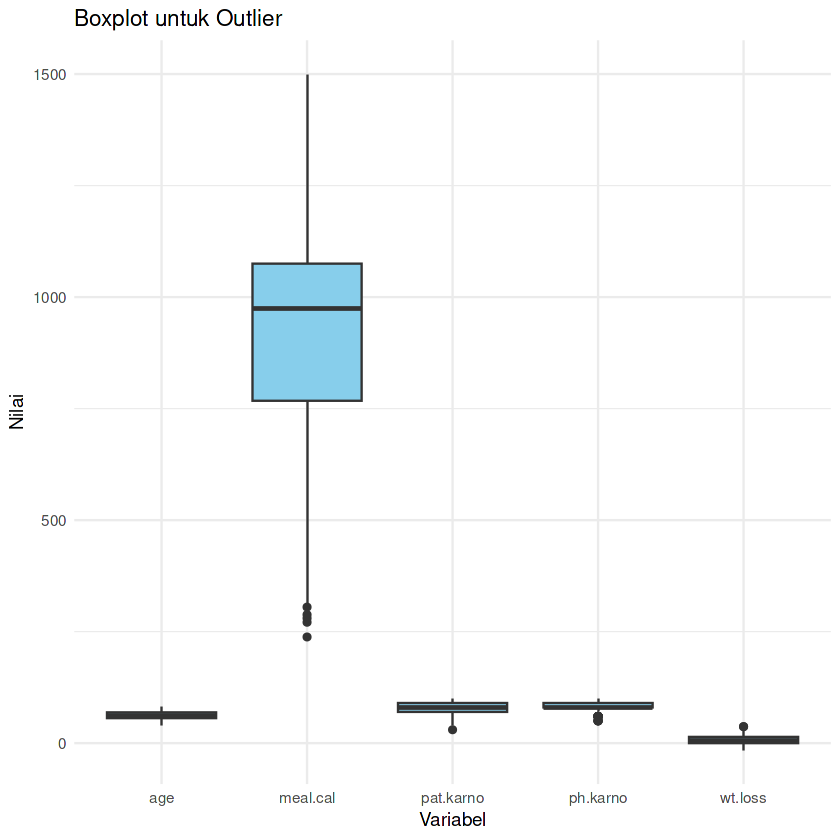

In [21]:
# Buat boxplot per variabel
data_clean %>%
  select(all_of(num_vars)) %>%
  pivot_longer(everything(), names_to = "variable", values_to = "value") %>%
  ggplot(aes(x = variable, y = value)) +
  geom_boxplot(fill = "skyblue") +
  theme_minimal() +
  labs(title = "Boxplot untuk Outlier", x = "Variabel", y = "Nilai")

Outlier sudah tidak ada.

# Encoding

In [22]:
# Tahap 2.3.3: Mengubah Variabel Numerik ke Kategorik

data_clean <- data_clean %>%
  mutate(
    age_cat = case_when(
      age < 60 ~ "Young",
      age >= 60 & age <= 70 ~ "Middle",
      age > 70 ~ "Old",
      TRUE ~ NA_character_
    ),
    ph.karno_cat = case_when(
      ph.karno <= 60 ~ "Low",
      ph.karno > 60 & ph.karno <= 80 ~ "Medium",
      ph.karno > 80 ~ "High",
      TRUE ~ NA_character_
    ),
    pat.karno_cat = case_when(
      pat.karno <= 60 ~ "Low",
      pat.karno > 60 & pat.karno <= 80 ~ "Medium",
      pat.karno > 80 ~ "High",
      TRUE ~ NA_character_
    ),
    meal.cal_cat = case_when(
      meal.cal <= 1000 ~ "Low",
      meal.cal > 1000 & meal.cal <= 2000 ~ "Medium",
      meal.cal > 2000 ~ "High",
      TRUE ~ NA_character_
    ),
    wt.loss_cat = case_when(
      wt.loss <= 0 ~ "Gain/Stable",
      wt.loss > 0 & wt.loss <= 10 ~ "MildLoss",
      wt.loss > 10 ~ "SevereLoss",
      TRUE ~ NA_character_
    )
  )

In [23]:
data_encoded <- data_clean %>%
  mutate(across(c(age_cat, sex, ph.karno_cat, pat.karno_cat, meal.cal_cat, wt.loss_cat), as.factor)) %>%
  fastDummies::dummy_cols(select_columns = c("age_cat", "sex", "ph.karno_cat", "pat.karno_cat", "meal.cal_cat", "wt.loss_cat"), remove_first_dummy = TRUE, remove_selected_columns = TRUE)

In [24]:
glimpse(data_encoded)

Rows: 208
Columns: 20
$ id                     <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, …
$ inst                   <dbl> 3, 3, 3, 5, 1, 12, 7, 11, 1, 7, 6, 16, 11, 1, 2…
$ time                   <dbl> 306, 455, 1010, 210, 883, 1022, 310, 361, 218, …
$ status                 <dbl> 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,…
$ age                    <dbl> 74, 68, 56, 57, 60, 74, 68, 71, 53, 61, 57, 68,…
$ ph.ecog                <dbl> 1, 0, 0, 1, 0, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2,…
$ ph.karno               <dbl> 90, 90, 90, 90, 100, 50, 70, 60, 70, 70, 80, 70…
$ pat.karno              <dbl> 100, 90, 90, 60, 90, 80, 60, 80, 80, 70, 80, 70…
$ meal.cal               <dbl> 1175.0000, 1225.0000, 1070.5412, 1150.0000, 102…
$ wt.loss                <dbl> 7, 15, 15, 11, 0, 0, 10, 1, 16, 34, 27, 23, 5, …
$ age_cat_Old            <int> 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,…
$ age_cat_Young          <int> 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,…
$ sex_2           

# Kaplan Meier

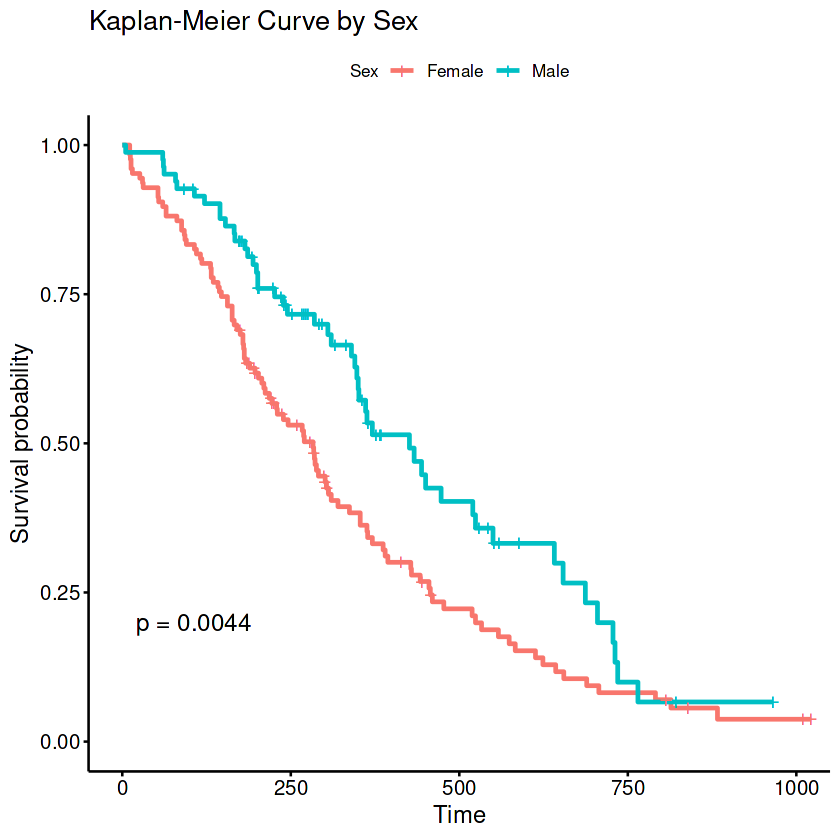

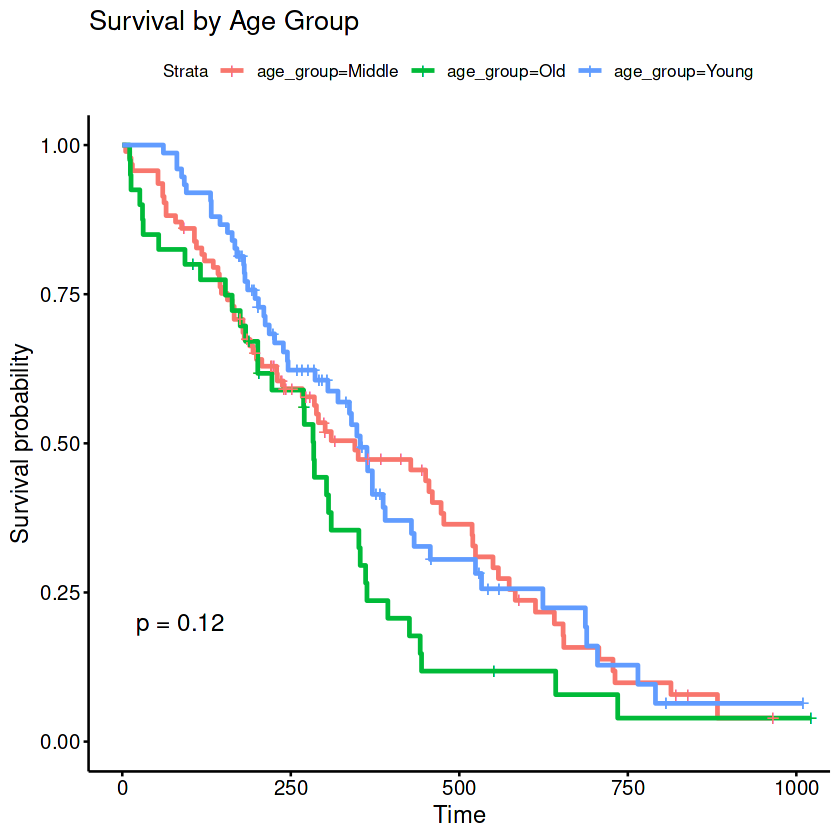

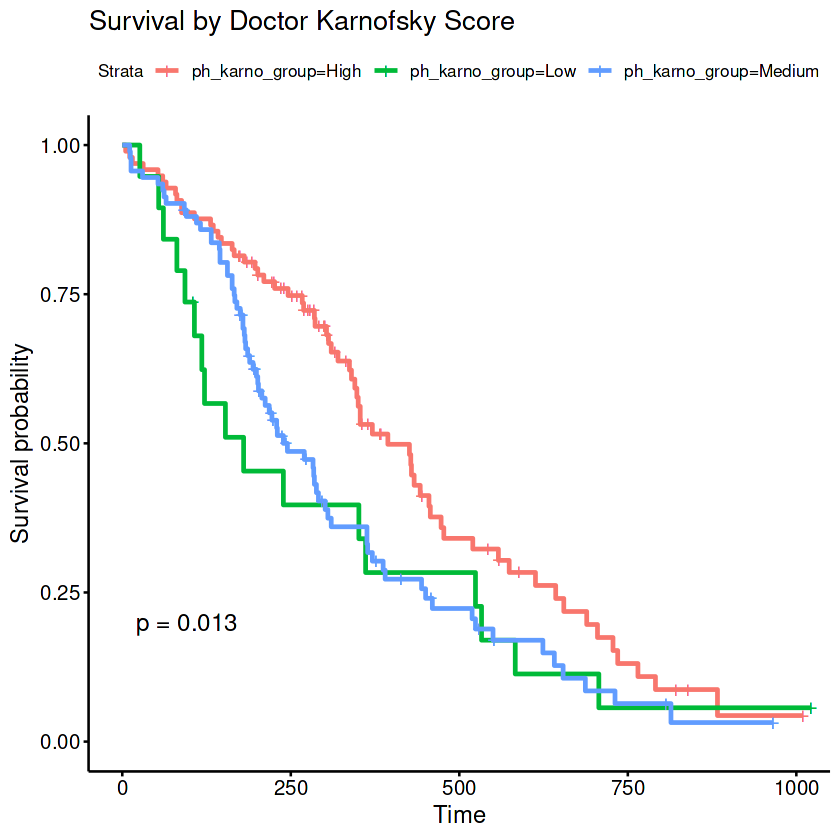

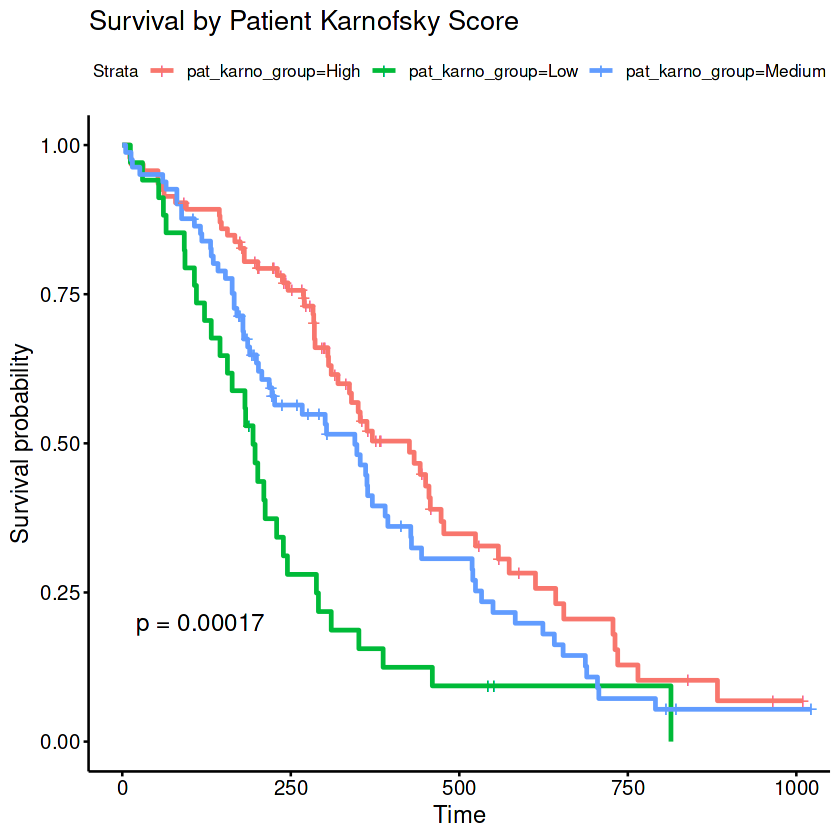

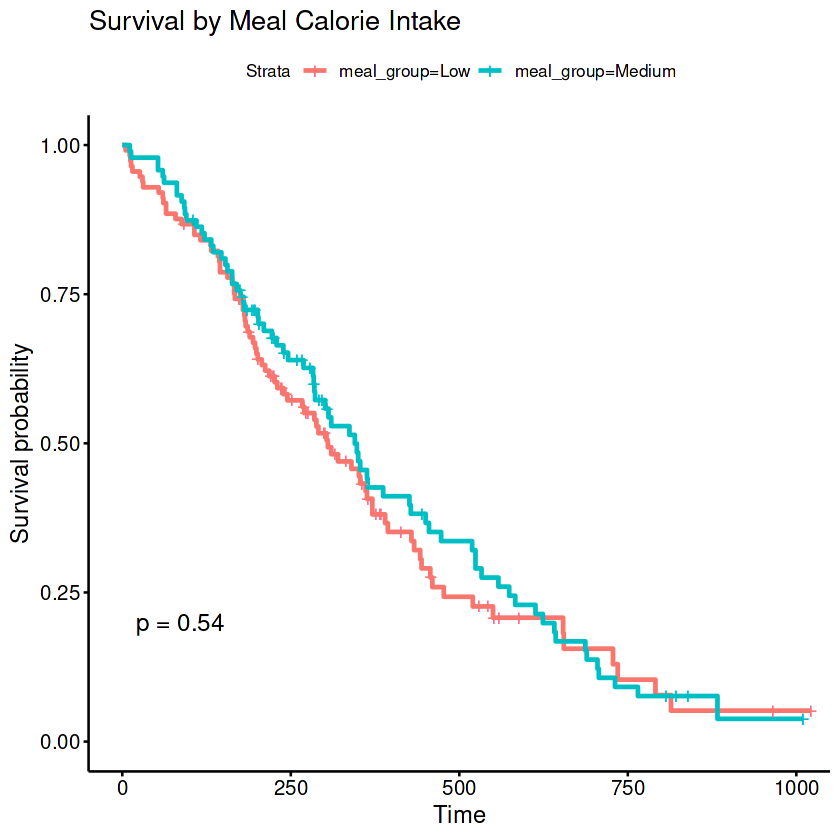

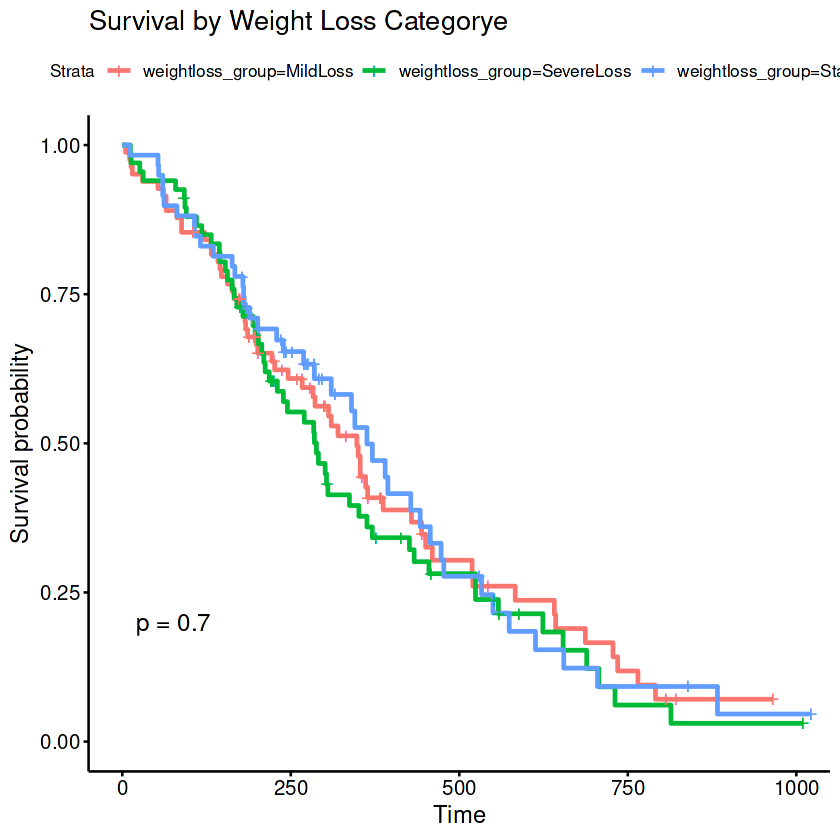

In [44]:
# Buat objek survival
surv_obj <- Surv(time = data_encoded$time, event = data_encoded$status == 2)

# 1. Kaplan-Meier berdasarkan Jenis Kelamin
km_sex <- survfit(surv_obj ~ sex_2, data = data_encoded)
ggsurvplot(km_sex, data = data_encoded,
           legend.title = "Sex",
           legend.labs = c("Female", "Male"),
           pval = TRUE,
           title = "Kaplan-Meier Curve by Sex")

# 2. Berdasarkan Usia (Kategori)
km_age <- survfit(surv_obj ~ age_cat_Old + age_cat_Young, data = data_encoded)
data_encoded$age_group <- factor(ifelse(data_encoded$age_cat_Old == 1, "Old",
                                  ifelse(data_encoded$age_cat_Young == 1, "Young", "Middle")))
km_age_grp <- survfit(surv_obj ~ age_group, data = data_encoded)
ggsurvplot(km_age_grp, data = data_encoded,
           title = "Survival by Age Group",
           pval = TRUE)

# 3. Berdasarkan ph.karno_cat
data_encoded$ph_karno_group <- factor(with(data_encoded,
                                  ifelse(ph.karno_cat_Low == 1, "Low",
                                  ifelse(ph.karno_cat_Medium == 1, "Medium", "High"))))
km_ph_karno <- survfit(surv_obj ~ ph_karno_group, data = data_encoded)
ggsurvplot(km_ph_karno, data = data_encoded,
           title = "Survival by Doctor Karnofsky Score",
           pval = TRUE)

# 4. Berdasarkan pat.karno_cat
data_encoded$pat_karno_group <- factor(with(data_encoded,
                                  ifelse(pat.karno_cat_Low == 1, "Low",
                                  ifelse(pat.karno_cat_Medium == 1, "Medium", "High"))))
km_pat_karno <- survfit(surv_obj ~ pat_karno_group, data = data_encoded)
ggsurvplot(km_pat_karno, data = data_encoded,
           title = "Survival by Patient Karnofsky Score",
           pval = TRUE)

# 5. Berdasarkan meal.cal_cat
data_encoded$meal_group <- factor(with(data_encoded,
                                ifelse(meal.cal_cat_Medium == 1, "Medium",
                                ifelse(meal.cal >= 2000, "High", "Low"))))
km_meal <- survfit(surv_obj ~ meal_group, data = data_encoded)
ggsurvplot(km_meal, data = data_encoded,
           title = "Survival by Meal Calorie Intake",
           pval = TRUE)

# 6. Berdasarkan wt.loss_cat
data_encoded$weightloss_group <- factor(with(data_encoded,
                              ifelse(wt.loss_cat_MildLoss == 1, "MildLoss",
                              ifelse(wt.loss_cat_SevereLoss == 1, "SevereLoss", "Stable"))))

km_wt <- survfit(surv_obj ~ weightloss_group, data = data_encoded)
ggsurvplot(km_wt, data = data_encoded,
           title = "Survival by Weight Loss Categorye",
           pval = TRUE)

# Membuat Model

In [25]:
surv_obj <- Surv(time = data_encoded$time, event = data_encoded$status == 2)

In [26]:
cox_model <- coxph(surv_obj ~ age_cat_Old + age_cat_Young + sex_2 +
                   ph.karno_cat_Low + ph.karno_cat_Medium +
                   pat.karno_cat_Low + pat.karno_cat_Medium +
                   meal.cal_cat_Medium +
                   wt.loss_cat_MildLoss + wt.loss_cat_SevereLoss,
                   data = data_encoded)

In [27]:
summary(cox_model)

Call:
coxph(formula = surv_obj ~ age_cat_Old + age_cat_Young + sex_2 + 
    ph.karno_cat_Low + ph.karno_cat_Medium + pat.karno_cat_Low + 
    pat.karno_cat_Medium + meal.cal_cat_Medium + wt.loss_cat_MildLoss + 
    wt.loss_cat_SevereLoss, data = data_encoded)

  n= 208, number of events= 152 

                            coef exp(coef)  se(coef)      z Pr(>|z|)   
age_cat_Old             0.363656  1.438579  0.220335  1.650  0.09885 . 
age_cat_Young          -0.026258  0.974084  0.191690 -0.137  0.89104   
sex_2                  -0.483850  0.616406  0.181053 -2.672  0.00753 **
ph.karno_cat_Low        0.139801  1.150045  0.318541  0.439  0.66075   
ph.karno_cat_Medium     0.313286  1.367912  0.200335  1.564  0.11786   
pat.karno_cat_Low       0.711860  2.037779  0.260437  2.733  0.00627 **
pat.karno_cat_Medium    0.223964  1.251026  0.208696  1.073  0.28320   
meal.cal_cat_Medium    -0.003366  0.996639  0.177396 -0.019  0.98486   
wt.loss_cat_MildLoss   -0.008173  0.991861  0.213020 -0.0

# Signifikansi

✅ Signifikan
Jenis kelamin (sex_2): Laki-laki memiliki risiko kematian lebih tinggi (p = 0.0075).

Skor Karnofsky pasien rendah (pat.karno_cat_Low): Meningkatkan risiko kematian 2 kali lipat (p = 0.0063).

⚠️ Cenderung Signifikan
Usia tua (age_cat_Old): Ada kecenderungan risiko lebih tinggi, tapi belum signifikan (p = 0.099).

❌ Tidak Signifikan
Usia muda (age_cat_Young), skor Karnofsky dokter, intake kalori (meal.cal), dan penurunan berat badan (wt.loss) tidak menunjukkan pengaruh signifikan terhadap risiko kematian.



# Plot

Plot berdasar kelamin.

In [28]:
ggsurv_sex <- ggsurvplot(
  survfit(Surv(time, status == 2) ~ sex_2, data = data_encoded),
  data = data_encoded,
  palette = "Set1",
  title = "Survival Curve by Sex",
  legend.labs = c("Male", "Female"),
  conf.int = TRUE,
  ggtheme = theme_minimal()
)

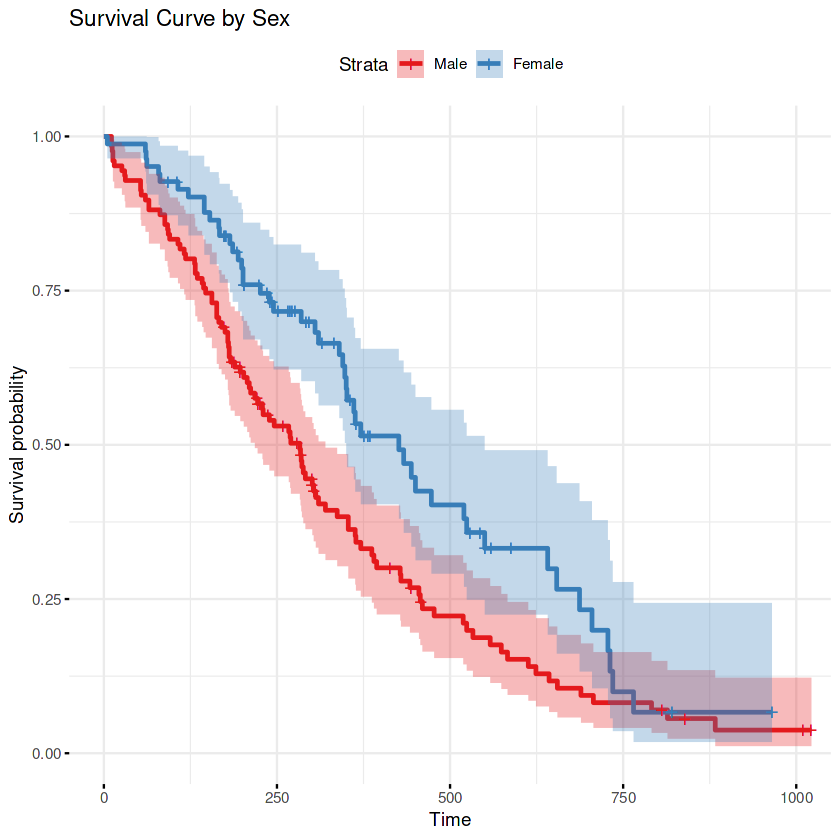

In [29]:
print(ggsurv_sex)

Plot berdasar umur.

In [30]:
ggsurv_age_cat <- ggsurvplot(
  survfit(Surv(time, status == 2) ~ age_cat, data = data_clean),
  data = data_clean,
  palette = "Set1",
  title = "Survival Curve by Age Category",
  legend.title = "Age Group",
  conf.int = TRUE,
  ggtheme = theme_minimal()
)

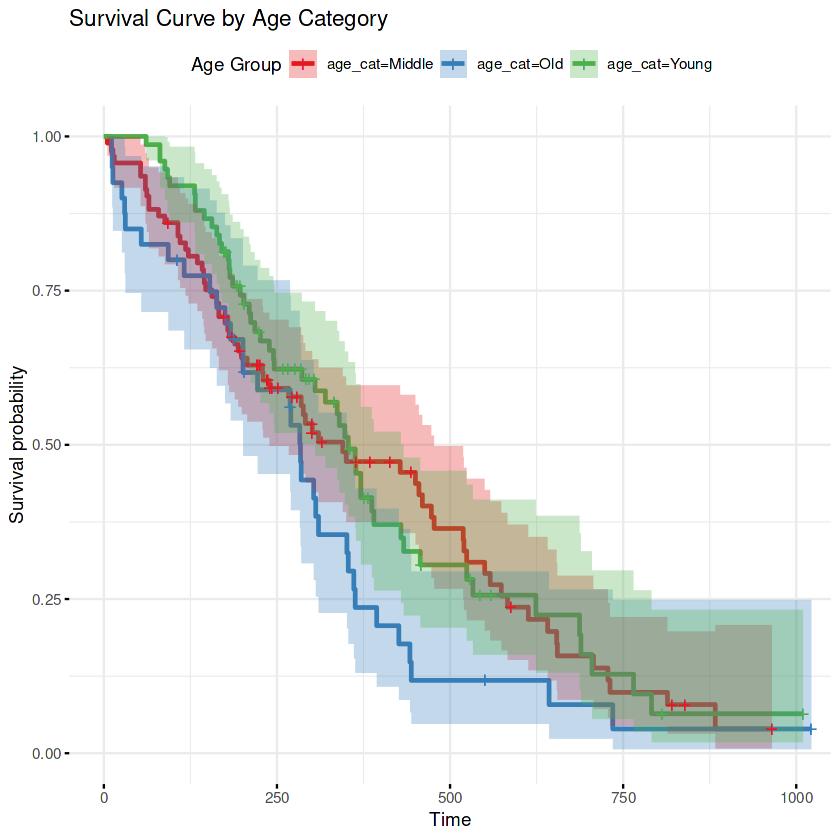

In [31]:
print(ggsurv_age_cat)

Plot berdasarkan ph.karno

In [32]:
ggsurv_phkarno <- ggsurvplot(
  survfit(Surv(time, status == 2) ~ ph.karno_cat, data = data_clean),
  data = data_clean,
  palette = "Dark2",
  title = "Survival Curve by Physician Karnofsky",
  legend.title = "Physician Karnofsky",
  conf.int = TRUE,
  ggtheme = theme_minimal()
)

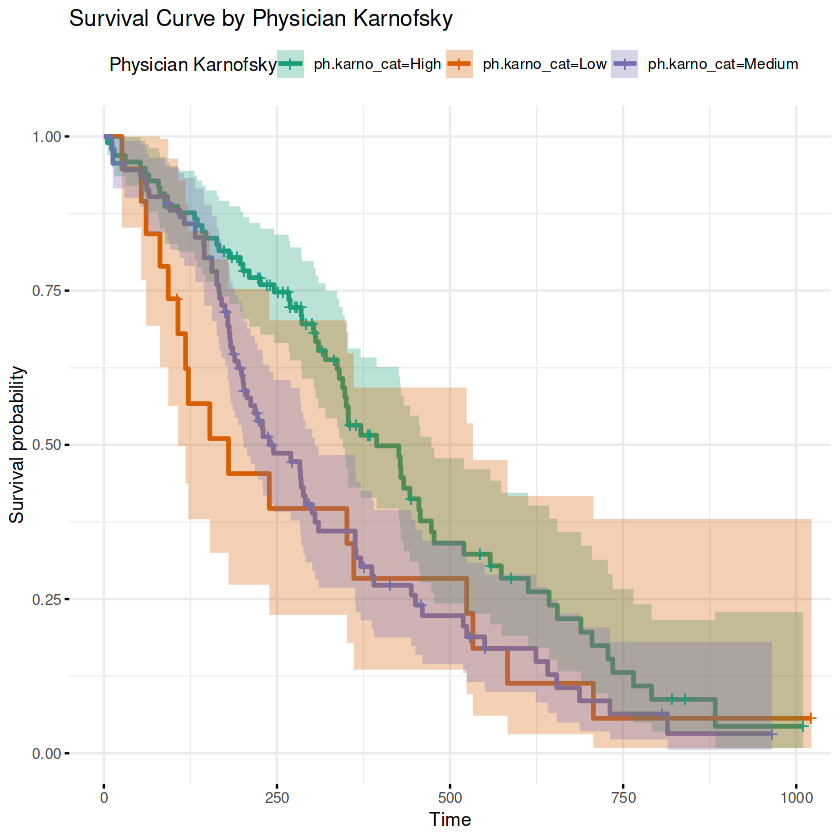

In [33]:
print(ggsurv_phkarno)

Plot berdasar pasien karno.

In [34]:
ggsurv_patkarno <- ggsurvplot(
  survfit(Surv(time, status == 2) ~ pat.karno_cat, data = data_clean),
  data = data_clean,
  palette = "Accent",
  title = "Survival Curve by Patient Karnofsky",
  legend.title = "Patient Karnofsky",
  conf.int = TRUE,
  ggtheme = theme_minimal()
)

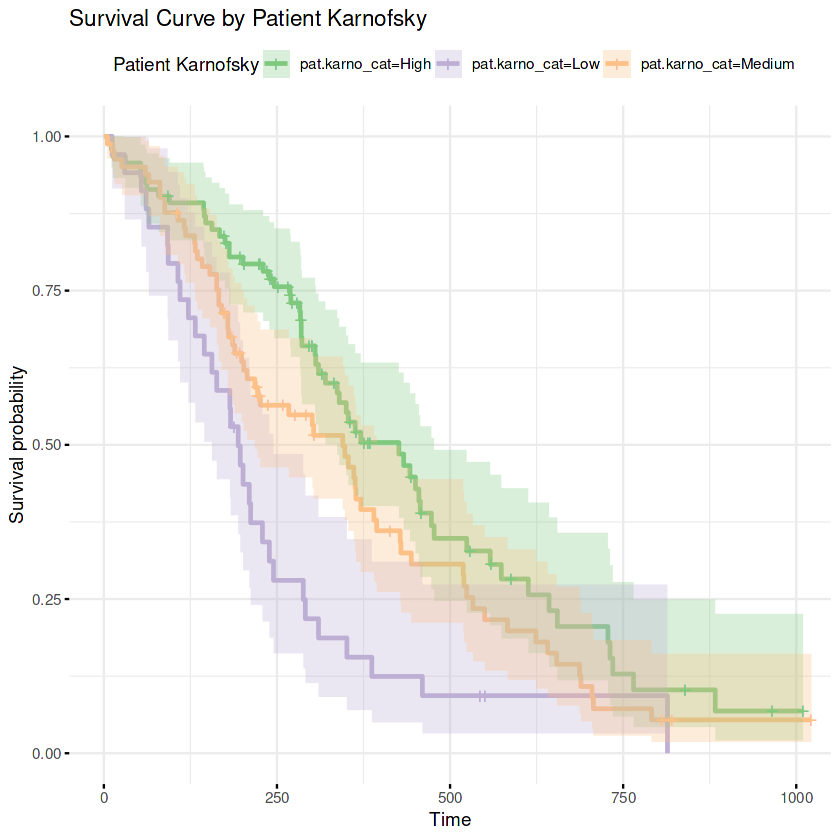

In [35]:
print(ggsurv_patkarno)

plot berdasar kalori makan.

In [36]:
ggsurv_mealcal <- ggsurvplot(
  survfit(Surv(time, status == 2) ~ meal.cal_cat, data = data_clean),
  data = data_clean,
  palette = "Set2",
  title = "Survival Curve by Meal Calories",
  legend.title = "Meal Calories",
  conf.int = TRUE,
  ggtheme = theme_minimal()
)

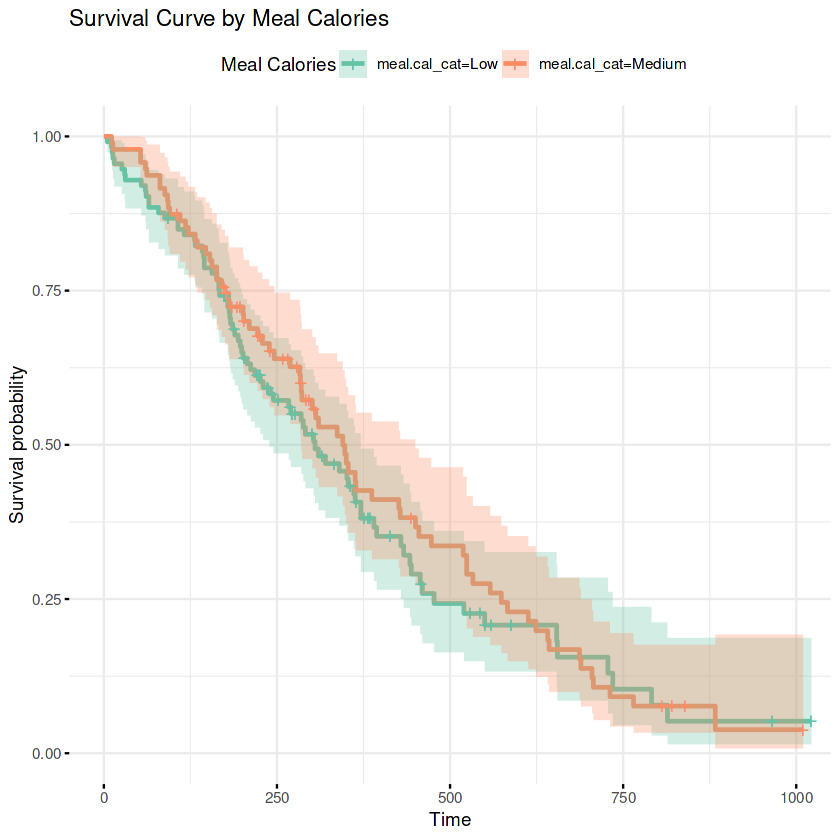

In [37]:
print(ggsurv_mealcal)

plot berdasar berat badan.

In [38]:
ggsurv_wtloss <- ggsurvplot(
  survfit(Surv(time, status == 2) ~ wt.loss_cat, data = data_clean),
  data = data_clean,
  palette = "Paired",
  title = "Survival Curve by Weight Loss Category",
  legend.title = "Weight Loss",
  conf.int = TRUE,
  ggtheme = theme_minimal()
)

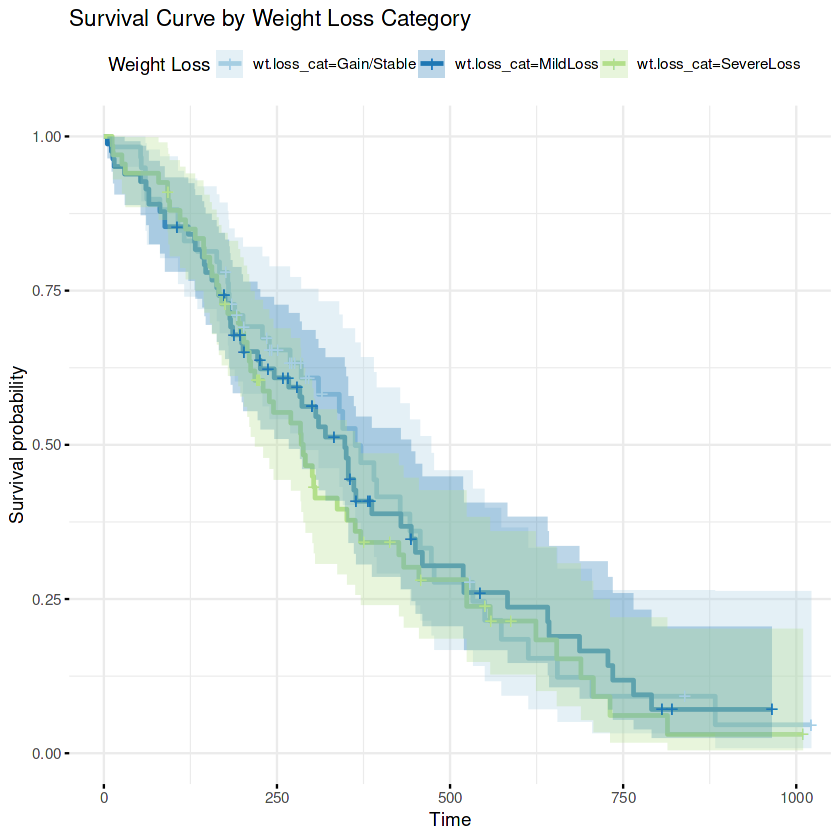

In [39]:
print(ggsurv_wtloss)

# Signifikansi Model

✅ Signifikan
Jenis kelamin (sex_2): Laki-laki memiliki risiko kematian lebih tinggi (p = 0.0075).

Skor Karnofsky pasien rendah (pat.karno_cat_Low): Meningkatkan risiko kematian 2 kali lipat (p = 0.0063).

⚠️ Cenderung Signifikan
Usia tua (age_cat_Old): Ada kecenderungan risiko lebih tinggi, tapi belum signifikan (p = 0.099).

❌ Tidak Signifikan
Usia muda (age_cat_Young), skor Karnofsky dokter, intake kalori (meal.cal), dan penurunan berat badan (wt.loss) tidak menunjukkan pengaruh signifikan terhadap risiko kematian.



# Kesimpulan

Pertanyaan	Jawaban	Status
Risiko kematian laki-laki vs perempuan	-> Ya, laki-laki lebih tinggi ->✅ Signifikan
Usia dan risiko kematian	-> Cenderung, tapi belum signifikan	 ->🟡 Marginal
Pengaruh skor Karnofsky	 -> Ya, skor rendah → risiko naik	-> ✅ Signifikan (pat.karno)
Kalori rendah → kematian	-> Tidak terbukti -> karena 🔴 Tidak signifikan